# Compare ExplainPolySVM with linear SVM with polynomial features on the Wisconsin Breast Cancer Dataset

In this example we compare the coefficients of the decision function of an SVM trained with a polynomial kernel of degree 1, i.e. a linear kernel, is identical to the coefficients of a linear SVM. We use the Wisconsin Breast Cancer Dataset [0] as the basis of this example.

The reason for the linear kernel, and not higher order polynomial, is that creating exactly the same polynomial features brings unnecessary complexity to this example. To create identical polynomial features, one can use Scikit-learn's preprocessing method PolynomialFeatures and then modify the polynomial features such that they produce the same dot products as the polynomial kernel corresponds to.

For the decision function coefficients for the SVM trained with the polynomial kernel we use ExPSVM.

For the decision function coefficients of the linear SVM, we use Scikit-learn's linear SVM implementation that solves the SVM in its primal form. After fitting the SVM we can simply extract the coefficients from the model.

To have identical kernels we use r=0 and gamma=1.

[0] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from explainpolysvm import expsvm

# Seed for reproducability
rng = np.random.default_rng(1011)


In [2]:
# Set to True to store figures in ./images
save_figs = False

In [3]:
data = load_breast_cancer()

In [4]:
X = data['data']
y = data['target']
f_names = data['feature_names']
y_names = data['target_names']

# In dataset, targets y are in {0,1}. We replace 0 with -1 to conform with standard SVM nomenclature
y[y==0] = -1

# Create dictionary mapping index of features to their names. Used for plotting.
f_name_dict = {str(num):name for num, name in enumerate(f_names)}
f_name_dict['constant'] = 'constant'  # Add constant to feature name dictionary

Split dataset into training, validation and test sets.

Then, normalize all three sets by the mean and standard deviation of the training set (standardization).

Finally, run hyperparameter sweep.

In [5]:
# Hyperparameters to sweep
Cs = np.arange(0.05, 1.55, 0.05)
d = 2
r = 0
gamma = 1
kernel = 'poly'

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Set up 5-fold crossvalidation
k = 5
n_train = X_train.shape[0]
fold_labels = rng.permutation(np.repeat(np.arange(k), np.ceil(n_train/k)))[0:n_train]

# Results array from hyperparameter sweep, columns are [C, d, r, acc]
res = np.zeros((len(Cs),2))

ind = 0
for C in Cs:
    n_correct = 0
    for fold in np.arange(k):
        # Get fold training and validation sets
        X_train_fold = X_train[fold_labels!=fold]
        y_train_fold = y_train[fold_labels!=fold]
        X_val_fold = X_train[fold_labels==fold]
        y_val_fold = y_train[fold_labels==fold]

        # Standardize data
        scaler = StandardScaler()
        scaler.fit(X_train_fold)
        X_train_fold = scaler.transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)

        # Train SVC
        model = SVC(C=C, kernel=kernel, degree=d, gamma=gamma, coef0=r)
        model.fit(X_train_fold, y_train_fold)

        # Predict validation set and couont number of correct predictions
        y_pred_fold = model.predict(X_val_fold)
        n_correct_fold = np.sum(y_val_fold==y_pred_fold)

        # Collect results
        n_correct += n_correct_fold

    # Collect used hyperparameters and go to next iteration
    res[ind,:] = np.array([C, n_correct/n_train])
    ind += 1
            
# Extract best hyperparameters
ind_best = np.argmax(res[:,1])
C_best, acc_best = res[ind_best, :]
print('Best hyperparameters found: C={:.1f}. 5-fold val. accuracy {:.3f}'.format(C_best, acc_best))

Best hyperparameters found: C=0.1. 5-fold val. accuracy 0.868


Retrain model with the combined training and validation sets, using the best hyperparameter combination, and evaluate on test set.

In [6]:
# Standardize training and test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Fit SVM
model = SVC(C=C_best, kernel=kernel, degree=d, gamma=gamma, coef0=r)
model.fit(X_train_scale, y_train)

# Test accuracy
test_acc = model.score(X_test_scale, y_test)
print('Test accuracy: {:.5f}'.format(test_acc))

Test accuracy: 0.84211


# Convert SVM with ExpSVM

In [7]:
# Extract model components
sv = model.support_vectors_
dual_coef = np.squeeze(model.dual_coef_)
intercept = model.intercept_[0]
kernel_gamma = model._gamma

# Instantiate ExPSVM
es = expsvm.ExPSVM(sv=sv, dual_coef=dual_coef, intercept=intercept,
                kernel_d=d, kernel_r=r, kernel_gamma=kernel_gamma)
es.transform_svm()

In [8]:
# Verify that performance has not changed (significantly) in the conversion.
y_pred = np.sign(es.decision_function(x=X_test_scale))
expsvm_acc = np.sum(y_pred==y_test)/y_test.size
print('Test accuracy with ExPSVM: {:.5f}. Difference between SVC and ExPSVM test accuracy (SVC_acc-ExPSVM_acc): {:.2e}'.format(expsvm_acc, test_acc-expsvm_acc))

Test accuracy with ExPSVM: 0.84211. Difference between SVC and ExPSVM test accuracy (SVC_acc-ExPSVM_acc): 0.00e+00


# Interaction importance

In [9]:
def format_interaction_names(feature_name_dict, feature_names_raw):
    """Format interaction names according to feature_name_dict.
    """
    interaction_names = []
    for ind, feat_name in enumerate(feature_names_raw):
        interaction_name = ')*('.join([feature_name_dict[f] for f in feat_name.split(',')])
        
        if '*' not in interaction_name:
            interaction_name = interaction_name.replace('(','').replace(')','')
        else:
            interaction_name = '(' + interaction_name + ')'
        interaction_names.append(interaction_name)
    return interaction_names

In [10]:
# Extract interaction importance from ExPSVM
feat_importance_magnitude, feat_names_magnitude, sort_order = es.feature_importance(format_names=False)

# Rename ExpSVM interactions with real feature names
interaction_names_magnitude = format_interaction_names(f_name_dict, feat_names_magnitude)

# Compare results with linear SVM trained with polynomial features

Scikit-learn has the functionality to calculate polynomial features. We can preprocess the data set to get the polynomial terms, and then train a linear SVM on the polynomial features. From the linear SVM we can directly calculate the coefficients in the decision function from the support vectors.

We use the same degree as the on found from the crossvalidation, i.e. 2.

To better compare the two models, we normalize the original features to zero mean and unit variance before we calculate the polynomial features. This is the same treatment as is done when using the polynomial kernel and ExPSVM.

(455, 496)
Test accuracy polynomial features: 0.94737 (poly. kernel accuracy: 0.84211)


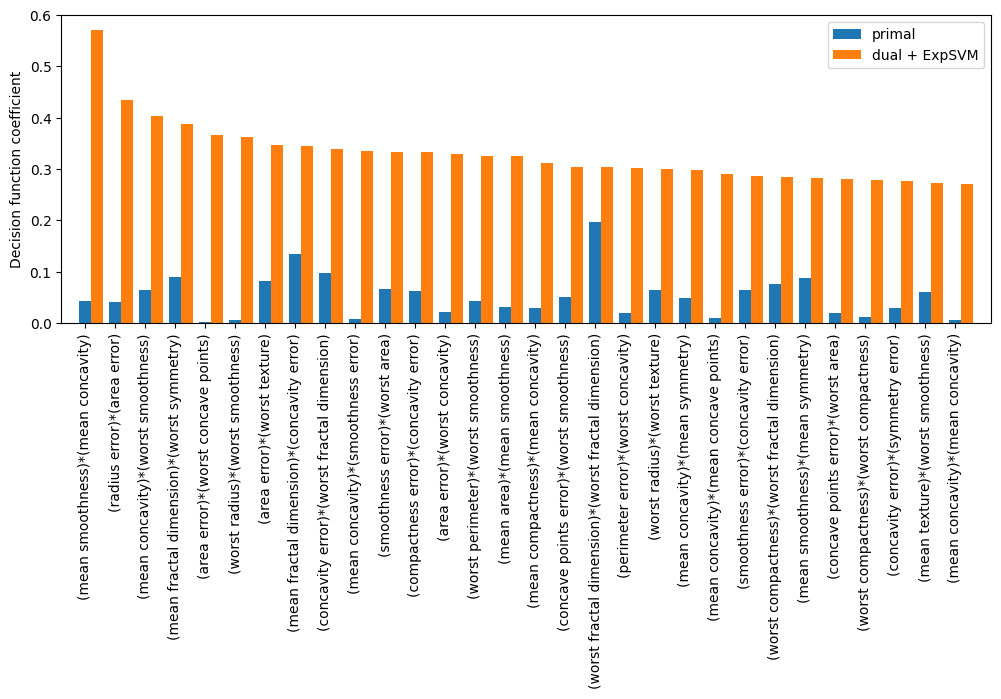

In [47]:
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial features
poly_f = PolynomialFeatures(degree=d, include_bias=True)
poly_f.fit(X_train_scale)

X_train_poly = poly_f.transform(X_train_scale)
X_test_poly = poly_f.transform(X_test_scale)

# To have the same kernel we need to zero all order-1 interactions, and multiply all cross-interactions
# e.g. x_i*x_j, with sqrt(2)
poly_names = poly_f.get_feature_names_out()
# print(poly_names)
print(X_train_poly.shape)
# Zero all original features
orig_feat = [ind for ind, name in enumerate(poly_names) if len(name)<4]
cross_int = [ind for ind, name in enumerate(poly_names) if (' ' in name)]

# Rename poly features to same format as ExPSVM
poly_names = [n.replace(' ',',').replace('x','') for n in poly_names]
poly_names = [n if '^' not in n else ','.join([n.split('^')[0]]*int(n.split('^')[1])) for n in poly_names]
poly_names_full = np.array(format_interaction_names(f_name_dict, poly_names))

# THIS SECTION IS WRONG, GO BACK AND WRITE OUT POLYNOMIAL TRANSFORMATION ON PAPER TO SET IT PROPERLY
X_train_poly[:, orig_feat] = 0
X_train_poly[:, cross_int] = X_train_poly[:, cross_int] * np.sqrt(2)
X_test_poly[:, orig_feat] = 0
X_test_poly[:, cross_int] = X_test_poly[:, cross_int] * np.sqrt(2)


# Train Linear SVM, with the same C (gamma and r are not relevant for the linear kernel)
lin_model = SVC(C=C_best, kernel='linear')

# Fit model
lin_model.fit(X_train_poly, y_train)

# Test accuracy
test_acc_poly = lin_model.score(X_test_poly, y_test)
print('Test accuracy polynomial features: {:.5f} (poly. kernel accuracy: {:.5f})'.format(test_acc_poly, test_acc))

# Get coefficients from linear SVM
coef = lin_model.coef_[0]
coef_abs = np.abs(coef)

# Sort linear SVM coefficients in order given by ExPSVM
sort_order_poly = np.flip(np.argsort(coef_abs))
poly_interaction_order = [np.where(poly_names_full==f'{find}')[0][0] for find in interaction_names_magnitude]

# Number of features to plot
n_feat_plot = 30

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.bar(x=np.arange(n_feat_plot)-0.2, height=np.abs(coef[poly_interaction_order[0:n_feat_plot]]), tick_label=interaction_names_magnitude[0:n_feat_plot], width=0.4)
ax.bar(x=np.arange(n_feat_plot)+0.2, height=feat_importance_magnitude[0:n_feat_plot], width=0.4)
plt.xticks(rotation=90)
plt.ylabel('Decision function coefficient')
# plt.title('Comparison Interaction importance for linear SVM')
plt.legend(['primal', 'dual + ExpSVM'])
plt.xlim([-1, n_feat_plot])
if save_figs:
    plt.savefig('./images/lin_svm_interaction_importance_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.draw()

In [44]:
np.abs(coef[poly_interaction_order])/feat_importance_magnitude

C:\Users\rikvi\AppData\Local\Temp\ipykernel_10036\2299668854.py:1: RuntimeWarning: invalid value encountered in divide
  np.abs(coef[poly_interaction_order])/feat_importance_magnitude


array([0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 1.        , 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 1.        , 0.70710678, 0.70710678, 1.        ,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 1.        , 0.70710678, 0.70710678,
       0.70710678, 1.        , 0.70710678, 0.70710678, 1.        ,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       1.        , 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710

Results are as expected, the two models create the same decision function and therefore the coefficients of the decision function are the same.